# TP3 : clustering et word2vec

# Clustering

### Imports

In [5]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [6]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/laure-
[nltk_data]     annemassart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
data_path = "../data/txt/"

In [8]:
DECADE = '1960'

### Charger les fichiers de la décennie + créer une liste de textes

In [9]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [10]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

### TF-IDF

In [11]:
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [12]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Matrice de vecteurs

In [13]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [14]:
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [15]:
#vector[0] = 1er doc de la liste
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

rossel        0.429822
ecrire        0.290745
agence        0.287284
bilingue      0.195608
importante    0.172357
                ...   
er            0.000000
erreurs       0.000000
esp           0.000000
espagne       0.000000
♦             0.000000
Length: 2997, dtype: float64

### Clustering sur vecteurs TF-IDF

### Définir un nombre de clusters

In [16]:
N_CLUSTERS = 3

In [17]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering

In [18]:
clusters = km_model.fit_predict(tfidf_vectors)

In [19]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [20]:
pprint(dict(clustering))

{0: ['KB_JB838_1960-01-12_01-00011.txt',
     'KB_JB838_1960-01-13_01-00009.txt',
     'KB_JB838_1960-01-27_01-00006.txt',
     'KB_JB838_1960-01-28_01-00011.txt',
     'KB_JB838_1960-01-28_01-00021.txt',
     'KB_JB838_1960-01-30_01-00007.txt',
     'KB_JB838_1960-01-31_01-00024.txt',
     'KB_JB838_1960-02-19_01-00011.txt',
     'KB_JB838_1960-02-20_01-00006.txt',
     'KB_JB838_1960-02-26_01-00001.txt',
     'KB_JB838_1960-02-26_01-00011.txt',
     'KB_JB838_1960-03-04_01-00010.txt',
     'KB_JB838_1960-03-06_01-00004.txt',
     'KB_JB838_1960-03-08_01-00008.txt',
     'KB_JB838_1960-03-09_01-00001.txt',
     'KB_JB838_1960-03-12_01-00007.txt',
     'KB_JB838_1960-03-13_01-00009.txt',
     'KB_JB838_1960-03-16_01-00007.txt',
     'KB_JB838_1960-03-18_01-00009.txt',
     'KB_JB838_1960-03-20_01-00014.txt',
     'KB_JB838_1960-04-05_01-00004.txt',
     'KB_JB838_1960-04-06_01-00008.txt',
     'KB_JB838_1960-04-13_01-00002.txt',
     'KB_JB838_1960-04-16_01-00002.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions

In [21]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [22]:
reduced_vectors[:10]

array([[ 0.49940241, -0.43947916],
       [-0.22882534,  0.00137802],
       [-0.27935516, -0.01591   ],
       [ 0.28620178,  0.5167929 ],
       [ 0.30678363,  0.51829425],
       [-0.28971534, -0.09053834],
       [-0.04734939,  0.04053585],
       [-0.06057916,  0.11984381],
       [-0.22345179, -0.05226802],
       [-0.1213846 ,  0.07470429]])

### Générer le plot

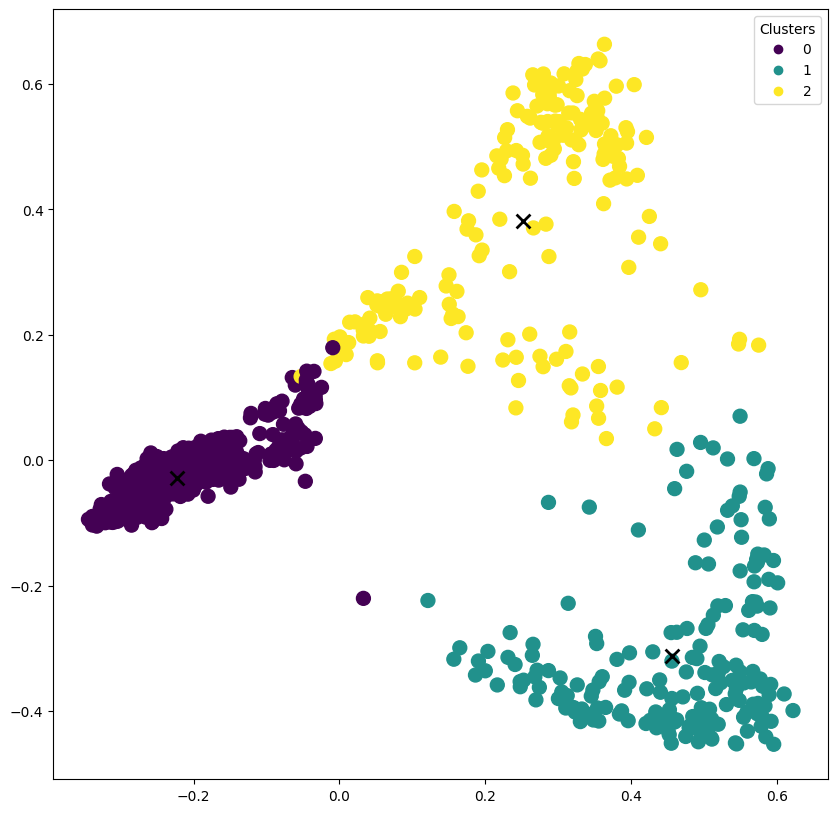

In [23]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Word Embeddings

### Imports & autres

In [24]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

In [25]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [26]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Extraction des bigrammes

In [27]:
bigram_phrases = Phrases(sentences)

In [28]:
type(bigram_phrases.vocab)

dict

In [29]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrammes

In [30]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [31]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création du corpus contenant les n-grammes

In [32]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [33]:
print(corpus[:100])

[['raege', 'quotidien', 'j00', 'exemplaires_distribues', 'gratuitement', '#', 'k', '.', "'", 'dans', 'ilagg', ';', 'lomeration', 'bruxelloise', 'et', '.', 'en_province', '.'], ['i', 'personnes_habitant_aux_etages', 'fenile', 'journal_contre', '60', 'c', '"<<', 'par_mois', '.'], ['fspir', 'est_expedie', 'en', 'proyinoe', 'contre', 't', '*>>"', 'par_mois', ',', 'payables_par_trimestre', '.'], ['annonces', ',', 'faits_divers', 'et', 'reclames', 'sjont', 'recu', 'frie', 'd', "'", 'isabelle', ';', 'a', 'l', "'", 'agence', 'rossfjl', '.'], ['44', '.'], ['-', 'v', ',', 'et', 'do', 'l', "'", 'enseignement', ',', 'a', 'braxell', 'annonces_remises_avant', 'midi', 'sont', ';', '-', 'a', ";'%", '>', '1', 'v', '>>^.'], [':', 'vv', '*', "*'*", 'hv', '/', 'f', '#-', 'v', '1', 'v', ';', "'", 'y', '>', 'fif', "'", 'ji', 'l', "'", 'h', '-', 'et', '.'], ['jeudi', '22_decembre', 'i887', 'observatoire', 'roy', "&'", 'cs', 'io', 'decembre', 's', 'heurts', 'uat', '$', 'r', '-:', 'r', 'quotidien_gratuit', 'te

### Entrainement du modèle Word2vec

In [34]:
%%time
model = Word2Vec(
    corpus, 
    vector_size=32, 
    window=5, 
    min_count=5, 
    workers=4, 
    epochs=5
)

CPU times: user 2min 59s, sys: 2.41 s, total: 3min 1s
Wall time: 1min 15s


In [35]:
#Sauver le modèle dans un fichier
outfile = f"../data/newspapers.model"
model.save(outfile)

### Explorer le modèle

In [36]:
model = Word2Vec.load("../data/newspapers.model")

In [57]:
model.wv.similarity("bruxelles", "paris")

0.6568638

In [85]:
model.wv.most_similar("feministe", topn=10)

[('dissidente', 0.929330050945282),
 ('des_massacres', 0.9178348183631897),
 ('hafid', 0.9151619076728821),
 ('paru_ce_matin', 0.9142099022865295),
 ('pour_hater', 0.9132450222969055),
 ('avait_propose', 0.9116879105567932),
 ('du_proletariat', 0.9109819531440735),
 ('en_ecoutant', 0.9099419713020325),
 ('au_drapeau', 0.9081041216850281),
 ('des_sites', 0.9080002903938293)]

In [39]:
print(model.wv.most_similar(positive=['paris', 'londres'], negative=['belgique']))

[('berlin', 0.8206422328948975), ('nice', 0.8105403780937195), ('marseille', 0.8023828268051147), ('dimanche', 0.7912279367446899), ('new_-_york', 0.7903247475624084), ('ce_matin', 0.7746368646621704), ('lundi_prochain', 0.756171703338623), ('rome', 0.7554802298545837), ('samedi', 0.7530423998832703), ('toulon', 0.7527065277099609)]
